# Recap: Data preprocessing

**Basic data transformation techniques**

Joaquin Vanschoren

In [3]:
# Auto-setup when running on Google Colab
import os
if 'google.colab' in str(get_ipython()) and not os.path.exists('/content/master'):
    !git clone -q https://github.com/ML-course/master.git /content/master
    !pip --quiet install -r /content/master/requirements_colab.txt
    %cd master/notebooks

# Global imports and settings
%matplotlib inline
from preamble import *
interactive = True # Set to True for interactive plots
if interactive:
    fig_scale = 0.9
    plt.rcParams.update(print_config)
else: # For printing
    fig_scale = 0.35
    plt.rcParams.update(print_config)

## Data transformations covered here

* Scaling and power transformations
* Unsupervised feature selection ()
    * Feature engineering (e.g. binning, polynomial features,...)
    * Handling missing data
    * Handling imbalanced data
    * Dimensionality reduction (e.g. PCA)
    * Learned embeddings (e.g. for text)
* Seek the best combinations of transformations and learning methods
    * Often done empirically, using cross-validation
    * Make sure that there is no data leakage during this process!

## Scaling
* Use when different numeric features have different scales (different range of values)
    * Features with much higher values may overpower the others
* Goal: bring them all within the same range
* Different methods exist

interactive(children=(Dropdown(description='scaler', options=(StandardScaler(), RobustScaler(), MinMaxScaler()…

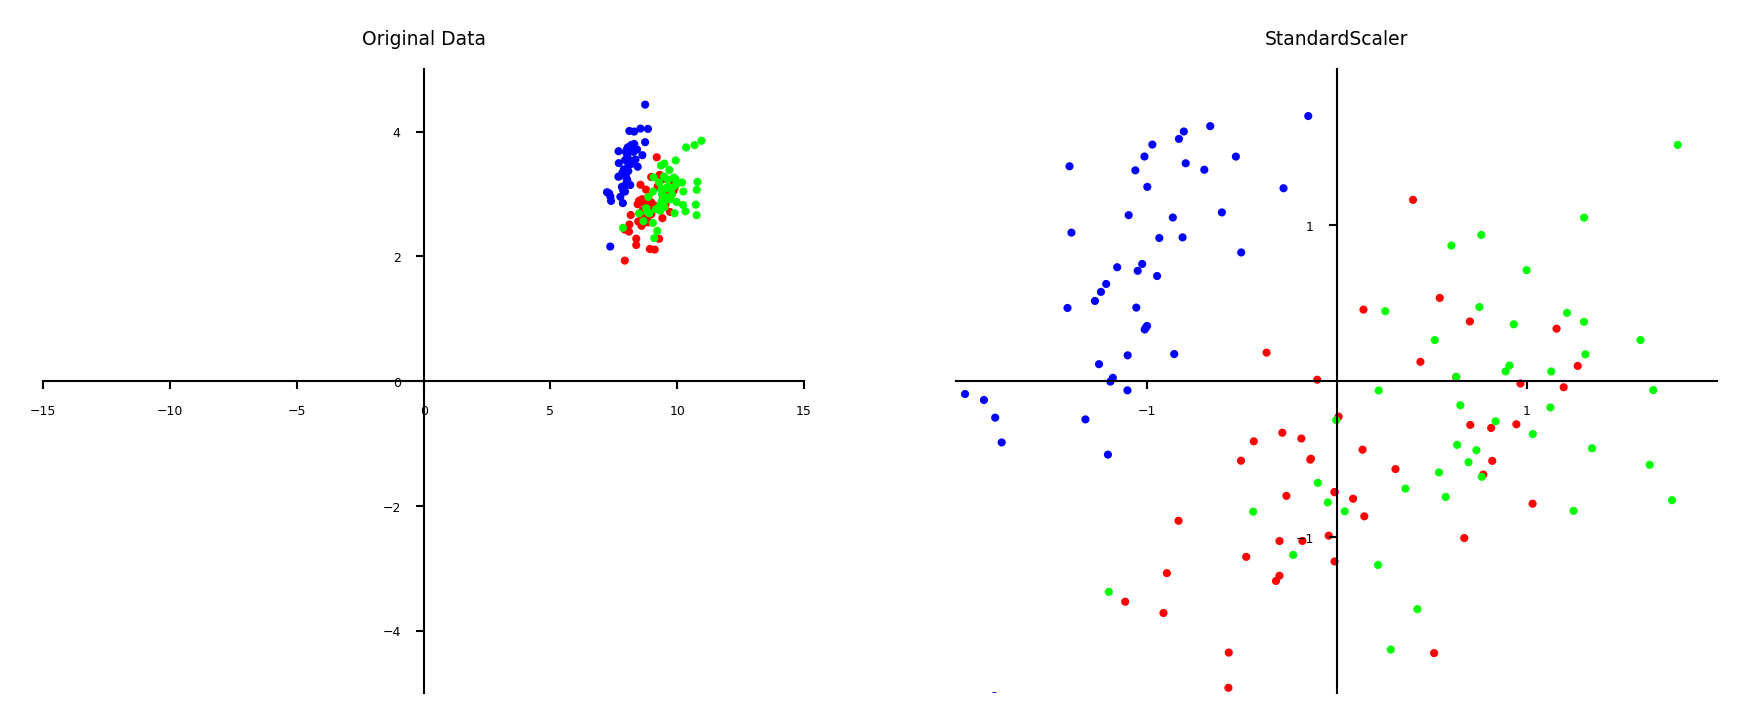

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler, Normalizer, MaxAbsScaler
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Iris dataset with some added noise
def noisy_iris():
    iris = fetch_openml("iris", return_X_y=True, as_frame=False)
    X, y = iris
    np.random.seed(0)
    noise = np.random.normal(0, 0.1, 150)
    for i in range(4):
        X[:, i] = X[:, i] + noise
    X[:, 0] = X[:, 0] + 3 # add more skew 
    label_encoder = LabelEncoder().fit(y)
    y = label_encoder.transform(y)
    return X, y

scalers = [StandardScaler(), RobustScaler(), MinMaxScaler(), Normalizer(norm='l1'), MaxAbsScaler()]

@interact
def plot_scaling(scaler=scalers):
    X, y = noisy_iris()
    X = X[:,:2] # Use only first 2 features
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8*fig_scale, 3*fig_scale))
    axes[0].scatter(X[:, 0], X[:, 1], c=y, s=1*fig_scale, cmap="brg")
    axes[0].set_xlim(-15, 15)
    axes[0].set_ylim(-5, 5)
    axes[0].set_title("Original Data")
    axes[0].spines['left'].set_position('zero')
    axes[0].spines['bottom'].set_position('zero')
    
    X_ = scaler.fit_transform(X)
    axes[1].scatter(X_[:, 0], X_[:, 1], c=y, s=1*fig_scale, cmap="brg")
    axes[1].set_xlim(-2, 2)
    axes[1].set_ylim(-2, 2)
    axes[1].set_title(type(scaler).__name__)
    axes[1].set_xticks([-1,1])
    axes[1].set_yticks([-1,1])
    axes[1].spines['left'].set_position('center')
    axes[1].spines['bottom'].set_position('center')

    for ax in axes:
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

In [3]:
if not interactive:
    plot_scaling(scalers[0])

### Why do we need scaling?
* KNN: Distances depend mainly on feature with larger values
* SVMs: (kernelized) dot products are also based on distances
* Linear model: Feature scale affects regularization
    * Weights have similar scales, more interpretable

interactive(children=(Dropdown(description='classifier', options=(KNeighborsClassifier(), SVC(), LinearSVC(), …

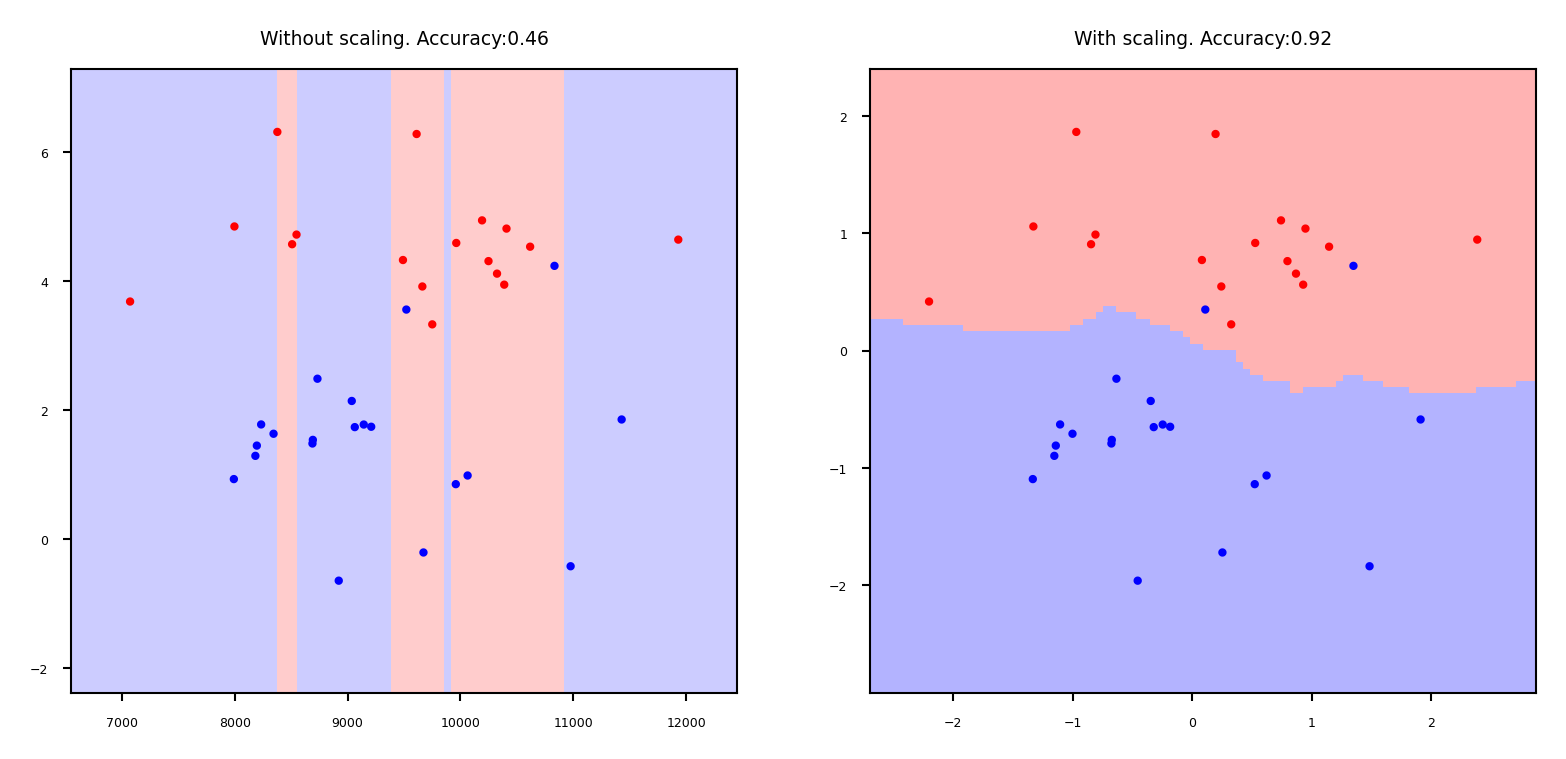

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.base import clone

# Example by Andreas Mueller, with some tweaks
def plot_2d_classification(classifier, X, fill=False, ax=None, eps=None, alpha=1):
    # multiclass                                                                  
    if eps is None:                                                               
        eps = X.std(axis=0) / 2.
    else:
        eps = np.array([eps, eps])

    if ax is None:                                                                
        ax = plt.gca()                                                            

    x_min, x_max = X[:, 0].min() - eps[0], X[:, 0].max() + eps[0]
    y_min, y_max = X[:, 1].min() - eps[1], X[:, 1].max() + eps[1]
    # these should be 1000 but knn predict is unnecessarily slow
    xx = np.linspace(x_min, x_max, 100)                                          
    yy = np.linspace(y_min, y_max, 100)                                          

    X1, X2 = np.meshgrid(xx, yy)                                                  
    X_grid = np.c_[X1.ravel(), X2.ravel()]                                        
    decision_values = classifier.predict(X_grid)                                  
    ax.imshow(decision_values.reshape(X1.shape), extent=(x_min, x_max,            
                                                       y_min, y_max),             
            aspect='auto', origin='lower', alpha=alpha, cmap=plt.cm.bwr)     

clfs = [KNeighborsClassifier(), SVC(), LinearSVC(), LogisticRegression(C=10)]

@interact
def plot_scaling_effect(classifier=clfs, show_test=[False,True]):
    X, y = make_blobs(centers=2, random_state=4, n_samples=50)
    X = X * np.array([1000, 1])
    y[7], y[27] = 0, 0 
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=1)
    
    clf2 = clone(classifier)
    clf_unscaled = classifier.fit(X_train, y_train)

    fig, axes = plt.subplots(1, 2, figsize=(7*fig_scale, 3*fig_scale))
    axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', label="train")
    axes[0].set_title("Without scaling. Accuracy:{:.2f}".format(clf_unscaled.score(X_test,y_test)))
    if show_test: # Hide test data for simplicity
        axes[0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='^', cmap='bwr', label="test") 
        axes[0].legend()
    
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    clf_scaled = clf2.fit(X_train_scaled, y_train)

    axes[1].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap='bwr', label="train")
    axes[1].set_title("With scaling. Accuracy:{:.2f}".format(clf_scaled.score(X_test_scaled,y_test)))   
    if show_test: # Hide test data for simplicity
        axes[1].scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test, marker='^', cmap='bwr', label="test")
        axes[1].legend()

    plot_2d_classification(clf_unscaled, X, ax=axes[0], alpha=.2)
    plot_2d_classification(clf_scaled, scaler.transform(X), ax=axes[1], alpha=.3)

In [5]:
if not interactive:
    plot_scaling_effect(classifier=clfs[0], show_test=False)

### Standard scaling (standardization)
* Generally most useful, assumes data is more or less normally distributed
* Per feature, subtract the mean value $\mu$, scale by standard deviation $\sigma$
* New feature has $\mu=0$ and $\sigma=1$, values can still be arbitrarily large
$$\mathbf{x}_{new} = \frac{\mathbf{x} - \mu}{\sigma}$$

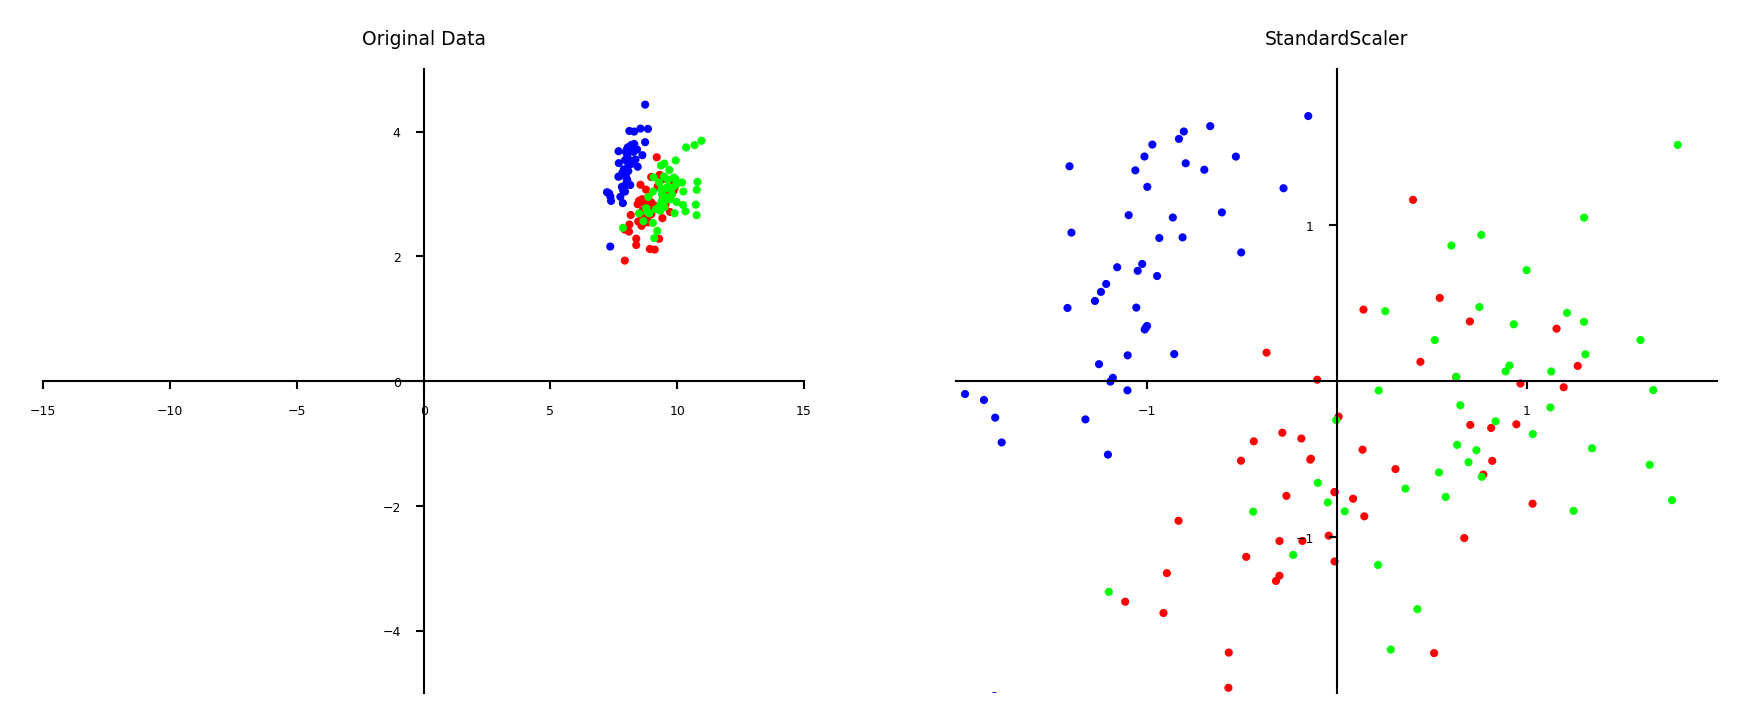

In [6]:
plot_scaling(scaler=StandardScaler())

### Min-max scaling
* Scales all features between a given $min$ and $max$ value (e.g. 0 and 1)
* Makes sense if min/max values have meaning in your data
* Sensitive to outliers

$$\mathbf{x}_{new} = \frac{\mathbf{x} - x_{min}}{x_{max} - x_{min}} \cdot (max - min) + min $$

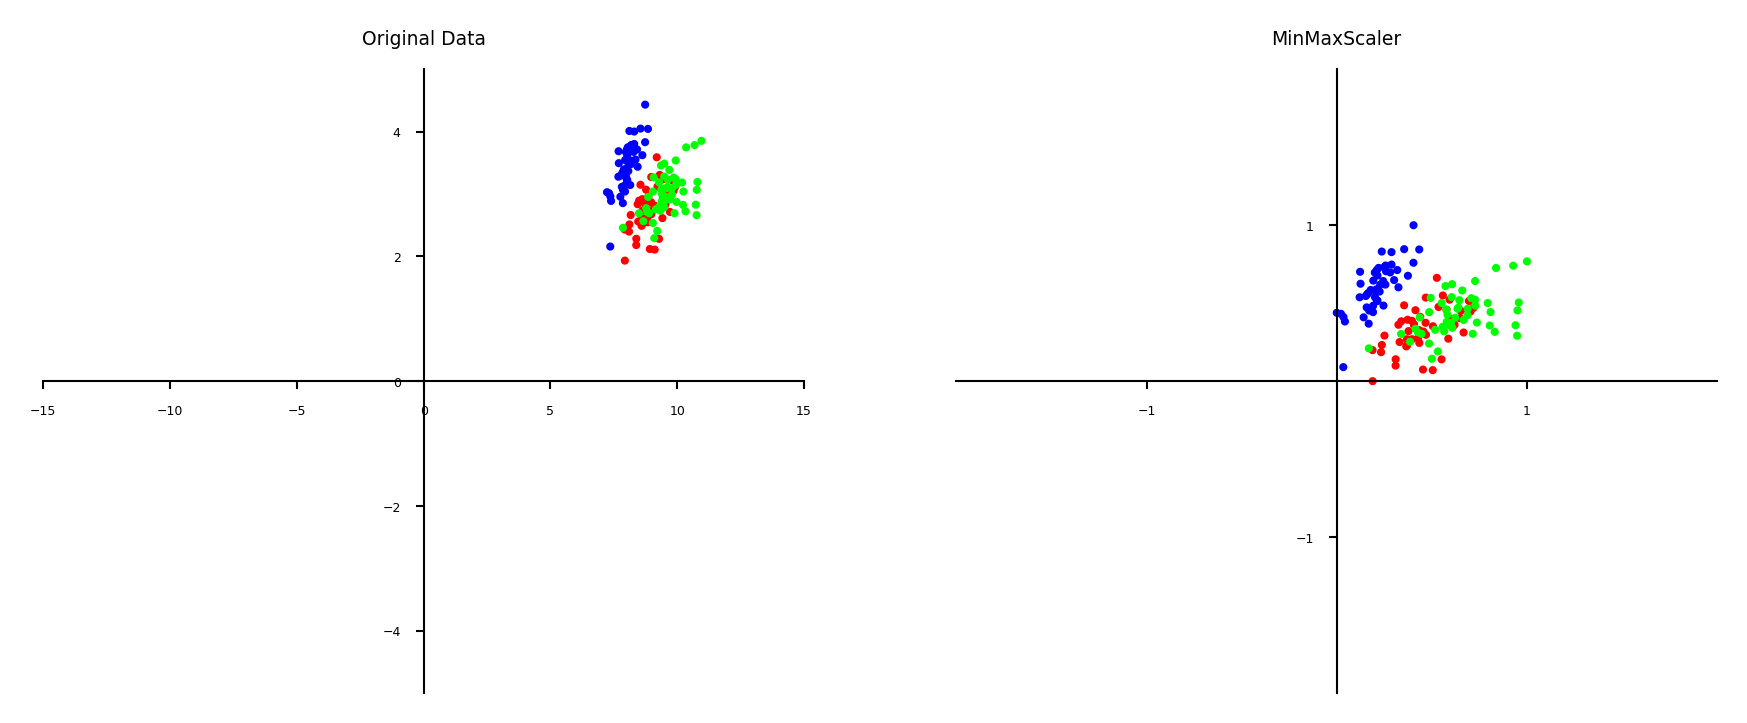

In [7]:
plot_scaling(scaler=MinMaxScaler(feature_range=(0, 1)))

### Robust scaling
* Subtracts the median, scales between quantiles $q_{25}$ and $q_{75}$
* New feature has median 0, $q_{25}=-1$ and $q_{75}=1$
* Similar to standard scaler, but ignores outliers

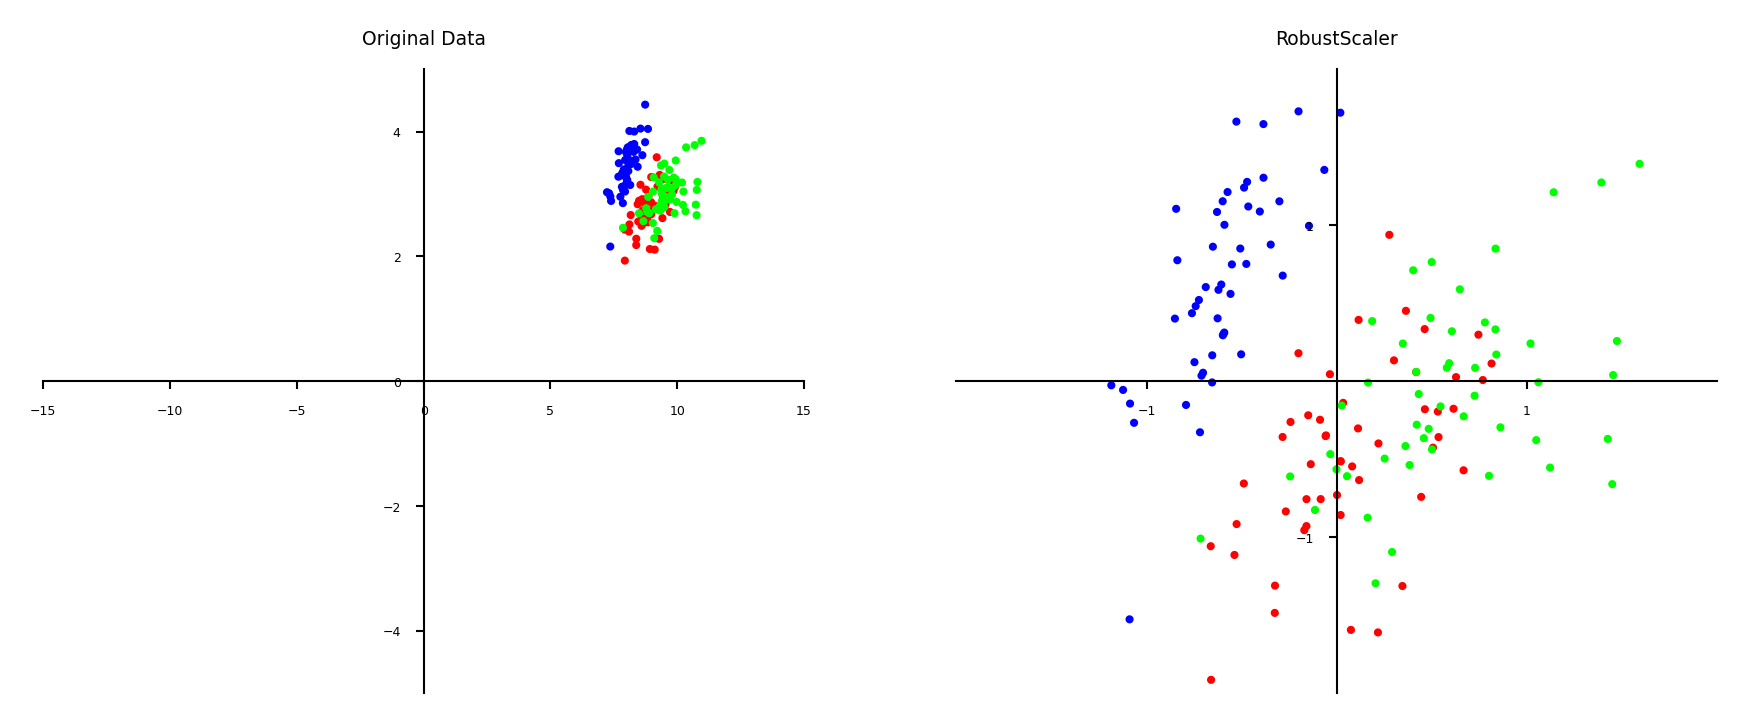

In [8]:
plot_scaling(scaler=RobustScaler())

### Normalization
* Makes sure that feature values of each point (each row) sum up to 1 (L1 norm)
    * Useful for count data (e.g. word counts in documents)
* Can also be used with L2 norm (sum of squares is 1)
    * Useful when computing distances in high dimensions
    * Normalized Euclidean distance is equivalent to cosine similarity 

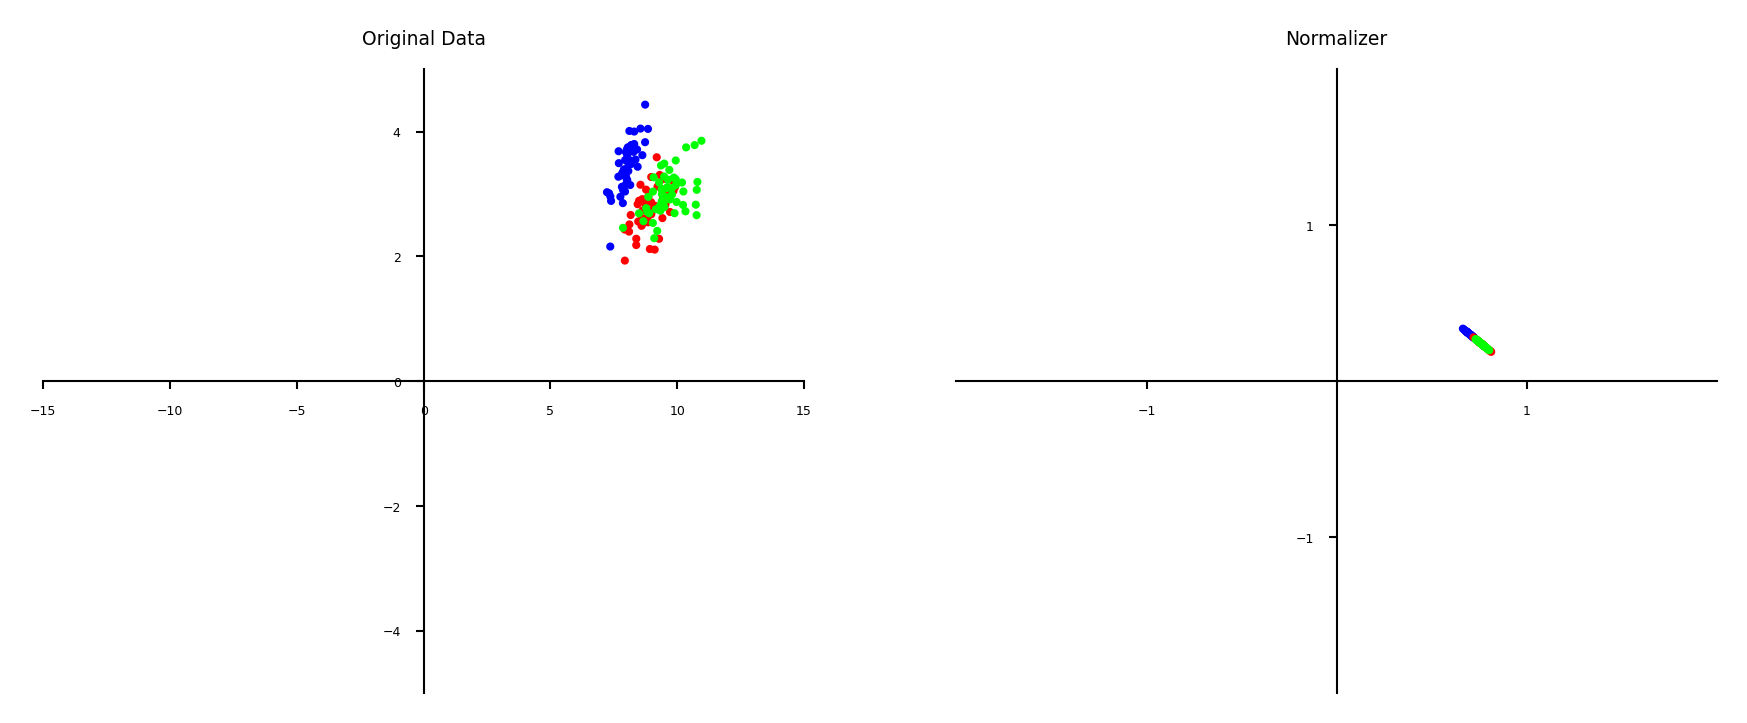

In [9]:
plot_scaling(scaler=Normalizer(norm='l1'))

### Maximum Absolute scaler
* For sparse data (many features, but few are non-zero)
    * Maintain sparseness (efficient storage)
* Scales all values so that maximum absolute value is 1
* Similar to Min-Max scaling without changing 0 values

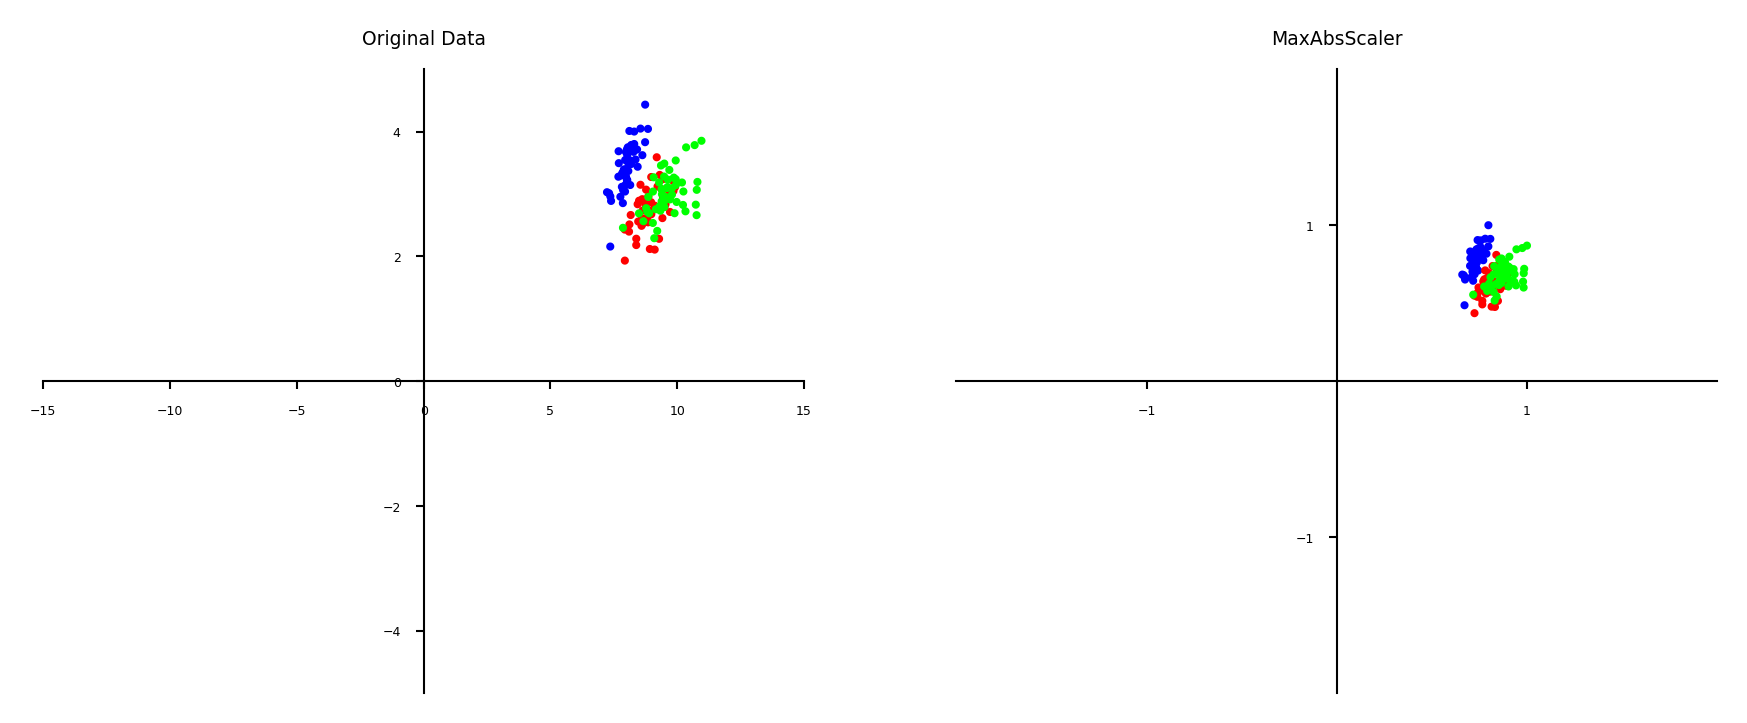

In [10]:
plot_scaling(scaler=MaxAbsScaler())

## Automatic Feature Selection

It can be a good idea to reduce the number of features to only the most useful ones
- Simpler models that generalize better (less overfitting)
    - Curse of dimensionality (e.g. kNN)
    - Even models such as RandomForest can benefit from this
    - Sometimes it is one of the main methods to improve models (e.g. gene expression data)
- Faster prediction and training
    - Training time can be quadratic (or cubic) in number of features
- Easier data collection, smaller models (less storage)
- More interpretable models: fewer features to look at

### Example: bike sharing
* The Bike Sharing Demand dataset shows the amount of bikes rented in Washington DC
* Some features are clearly more informative than others (e.g. temp, hour)
* Some are correlated (e.g. temp and feel_temp)
* We add two random features at the end

In [13]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Get bike sharing data from OpenML
bikes = fetch_openml(data_id=42713, as_frame=True)
X_bike_cat, y_bike = bikes.data, bikes.target

# Optional: take half of the data to speed up processing
X_bike_cat = X_bike_cat.sample(frac=0.5, random_state=1)
y_bike = y_bike.sample(frac=0.5, random_state=1)

# One-hot encode the categorical features
encoder = OneHotEncoder(dtype=int)
preprocessor = ColumnTransformer(transformers=[('cat', encoder, [0,7])], remainder='passthrough')
X_bike = preprocessor.fit_transform(X_bike_cat,y_bike)

# Add 2 random features at the end
random_features = np.random.rand(len(X_bike),2)
X_bike = np.append(X_bike,random_features, axis=1)

# Create feature names
bike_names = ['summer','winter', 'spring', 'fall', 'clear', 'misty', 'rain', 'heavy_rain']
bike_names.extend(X_bike_cat.columns[1:7])
bike_names.extend(X_bike_cat.columns[8:])
bike_names.extend(['random_1','random_2'])

In [14]:
#pd.set_option('display.max_columns', 20)
#pd.DataFrame(data=X_bike, columns=bike_names).head()

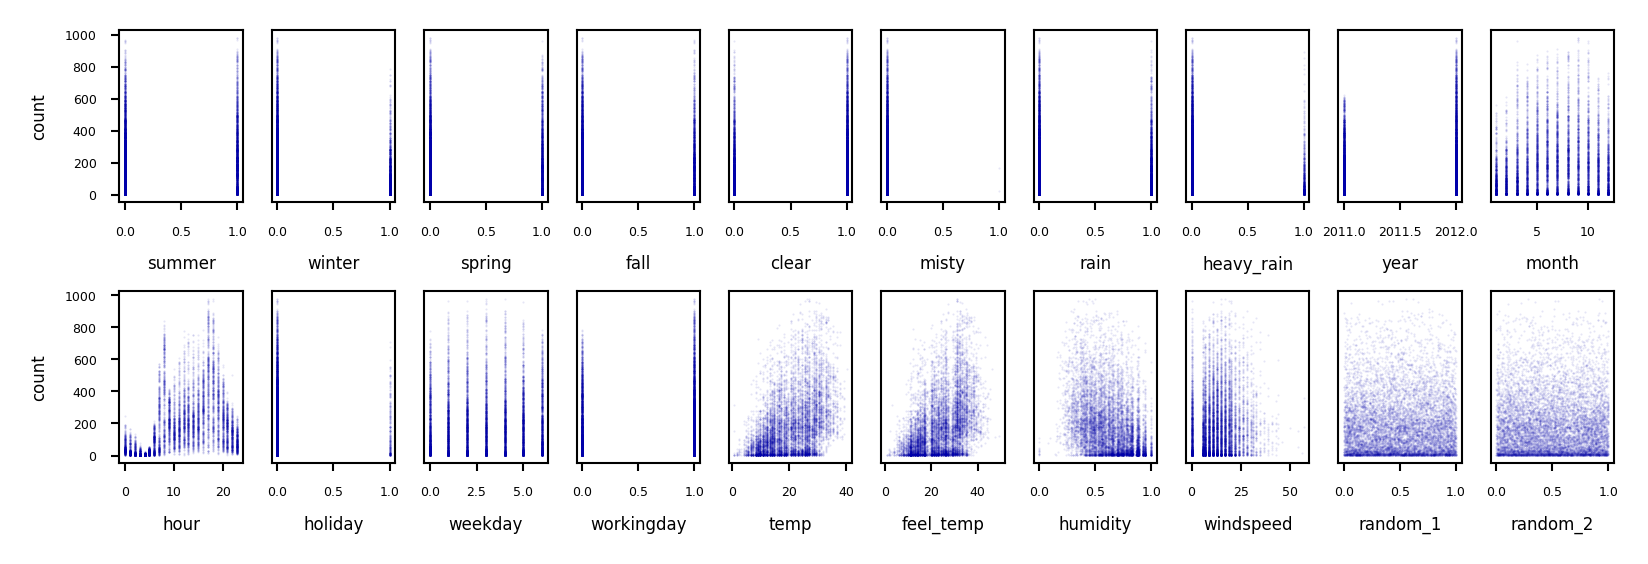

In [15]:
fig, axes = plt.subplots(2, 10, figsize=(6*fig_scale, 2*fig_scale))
for i, ax in enumerate(axes.ravel()):
    ax.plot(X_bike[:, i], y_bike[:], '.', alpha=.1)
    ax.set_xlabel("{}".format(bike_names[i]))
    ax.get_yaxis().set_visible(False)
for i in range(2):
    axes[i][0].get_yaxis().set_visible(True)
    axes[i][0].set_ylabel("count")
fig.tight_layout()

### Unsupervised feature selection
* Variance-based
    * Remove (near) constant feature: choose a small variance threshold
    * Scale features before computing variance!
    * Infrequent values may still be important
* Covariance-based
    * Remove correlated features
    * The small differences may actually be important
        * You don't know because you don't consider the target

In [20]:
from sklearn.feature_selection import f_regression, SelectPercentile, mutual_info_regression, SelectFromModel, RFE
from tqdm.notebook import trange, tqdm
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV



# Pre-compute all importances on bike sharing dataset
# Scaled feature selection thresholds
thresholds = [0.25, 0.5, 0.75, 1]
# Dict to store all data
fs = {}
methods = ['FTest','MutualInformation']
for m in methods:
    fs[m] = {}
    fs[m]['select'] = {}
    fs[m]['cv_score'] = {}

def cv_score(selector):
    model = RandomForestRegressor()
    select_pipe = make_pipeline(StandardScaler(), selector, model)    
    return np.mean(cross_val_score(select_pipe, X_bike, y_bike, cv=3))

# F test
print("Computing F test")
fs['FTest']['label'] = "F test"
fs['FTest']['score'] = f_regression(scale(X_bike),y_bike)[0]
fs['FTest']['scaled_score'] = fs['FTest']['score'] / np.max(fs['FTest']['score'])
for t in tqdm(thresholds):
    selector = SelectPercentile(score_func=f_regression, percentile=t*100).fit(scale(X_bike), y_bike)
    fs['FTest']['select'][t] = selector.get_support()
    fs['FTest']['cv_score'][t] = cv_score(selector)

# Mutual information
print("Computing Mutual information")
fs['MutualInformation']['label'] = "Mutual Information"
fs['MutualInformation']['score'] = mutual_info_regression(scale(X_bike),y_bike,discrete_features=range(13)) # first 13 features are discrete
fs['MutualInformation']['scaled_score'] = fs['MutualInformation']['score'] / np.max(fs['MutualInformation']['score'])
for t in tqdm(thresholds):
    selector = SelectPercentile(score_func=mutual_info_regression, percentile=t*100).fit(scale(X_bike), y_bike)
    fs['MutualInformation']['select'][t] = selector.get_support()
    fs['MutualInformation']['cv_score'][t] = cv_score(selector)
    
def plot_feature_importances(method1='f_test', method2=None, threshold=0.5):
    
    # Plot scores
    x = np.arange(20)
    fig, ax1 = plt.subplots(1, 1, figsize=(4*fig_scale, 1*fig_scale))
    w = 0.3
    imp = fs[method1]
    mask = imp['select'][threshold]
    m1 = ax1.bar(x[mask], imp['scaled_score'][mask], width=w, color='b', align='center')
    ax1.bar(x[~mask], imp['scaled_score'][~mask], width=w, color='b', align='center', alpha=0.3)
    if method2:
        imp2 = fs[method2]
        mask2 = imp2['select'][threshold]
        ax2 = ax1.twinx()
        m2 = ax2.bar(x[mask2] + w, imp2['scaled_score'][mask2], width=w,color='g',align='center')
        ax2.bar(x[~mask2] + w, imp2['scaled_score'][~mask2], width=w,color='g',align='center', alpha=0.3)
        plt.legend([m1, m2],['{} (Ridge R2:{:.2f})'.format(imp['label'],imp['cv_score'][threshold]),
                             '{} (Ridge R2:{:.2f})'.format(imp2['label'],imp2['cv_score'][threshold])], loc='upper left')
    else:
        plt.legend([m1],['{} (Ridge R2:{:.2f})'.format(imp['label'],imp['cv_score'][threshold])], loc='upper left')
    ax1.set_xticks(range(len(bike_names)))
    ax1.set_xticklabels(bike_names, rotation=45, ha="right");
    plt.title("Feature importance (selection threshold {:.2f})".format(threshold))
                        
    plt.show()

Computing F test


  0%|          | 0/4 [00:00<?, ?it/s]

Computing Mutual information


  0%|          | 0/4 [00:00<?, ?it/s]

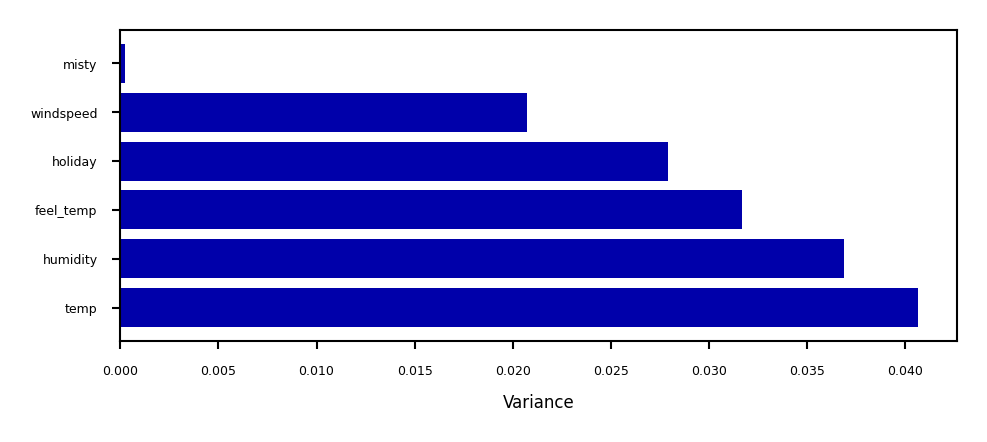

In [21]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold().fit(MinMaxScaler().fit_transform(X_bike))
variances = selector.variances_
var_sort = np.argsort(variances)

plt.figure(figsize=(4*fig_scale, 1.5*fig_scale))
ypos = np.arange(6)[::-1]
plt.barh(ypos, variances[var_sort][:6], align='center')
plt.yticks(ypos, np.array(bike_names)[var_sort][:6])
plt.xlabel("Variance");

#### Covariance based feature selection
* Remove features $X_i$ (= $\mathbf{X_{:,i}}$) that are highly correlated (have high correlation coefficient $\rho$)
$$\rho (X_1,X_2)={\frac  {{\mathrm  {cov}}(X_1,X_2)}{\sigma (X_1)\sigma (X_2)}} = {\frac { \frac{1}{N-1} \sum_i (X_{i,1} - \overline{X_1})(X_{i,2} - \overline{X_2}) }{\sigma (X_1)\sigma (X_2)}}$$
* Should we remove `feel_temp`? Or `temp`? Maybe one correlates more with the target?

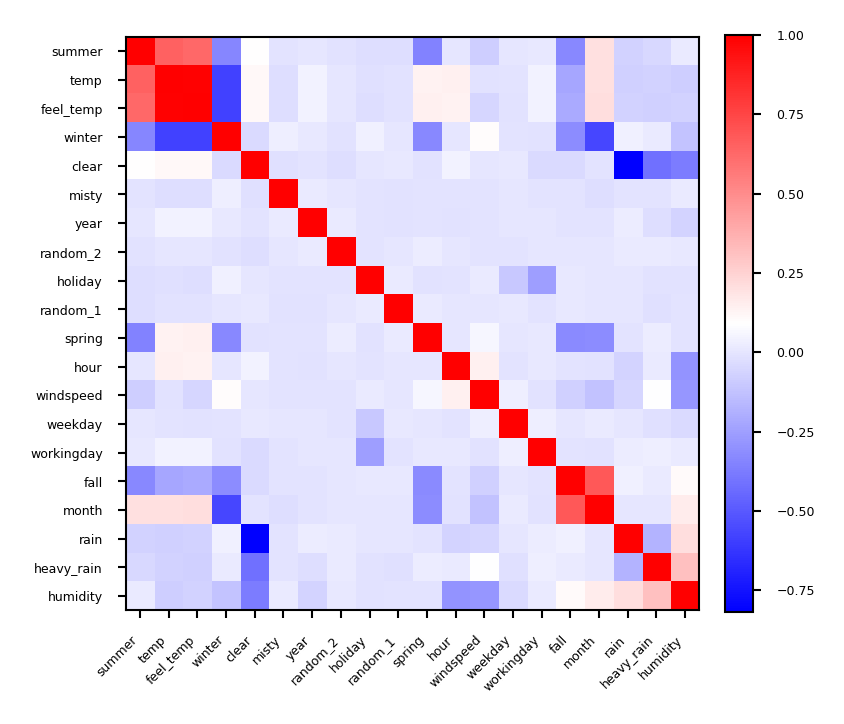

In [22]:
from sklearn.preprocessing import scale
from scipy.cluster import hierarchy

X_bike_scaled = scale(X_bike)
cov = np.cov(X_bike_scaled, rowvar=False)

order = np.array(hierarchy.dendrogram(hierarchy.ward(cov), no_plot=True)['ivl'], dtype="int")
bike_names_ordered = [bike_names[i] for i in order]

plt.figure(figsize=(3*fig_scale, 3*fig_scale))
plt.imshow(cov[order, :][:, order], cmap='bwr')
plt.xticks(range(X_bike.shape[1]), bike_names_ordered, ha="right")
plt.yticks(range(X_bike.shape[1]), bike_names_ordered)
plt.xticks(rotation=45)
plt.colorbar(fraction=0.046, pad=0.04);

### Univariate statistics (F-test)

* Consider each feature individually (univariate), independent of the model that you aim to apply
* Use a statistical test: is there a _linear_ __statistically significant relationship__ with the target?
* Use F-statistic (or corresponding p value) to rank all features, then select features using a threshold
    * Best $k$, best $k$ %, probability of removing useful features (FPR),...
* Cannot detect correlations (e.g. temp and feel_temp) or interactions (e.g. binary features)


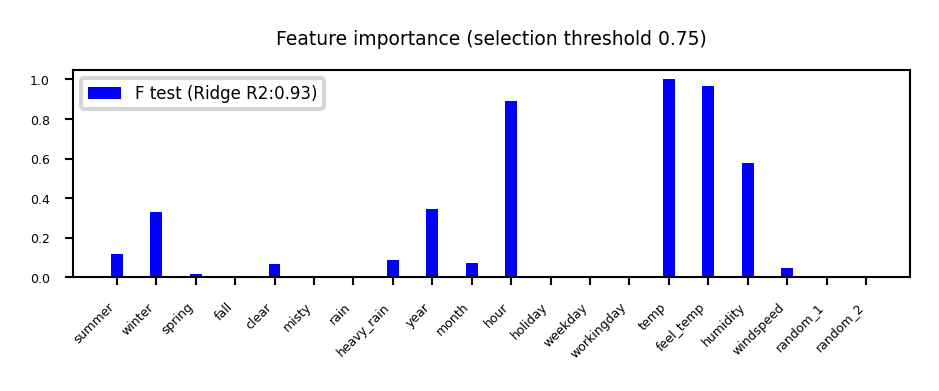

In [23]:
plot_feature_importances('FTest', None, threshold=0.75)

#### F-statistic

* For regression: does feature $X_i$ correlate (positively or negatively) with the target $y$?
$$\text{F-statistic} = \frac{\rho(X_i,y)^2}{1-\rho(X_i,y)^2} \cdot (N-1)$$
* For classification: uses ANOVA: does $X_i$ explain the between-class variance?
    * Alternatively, use the $\chi^2$ test (only for categorical features)
$$\text{F-statistic} = \frac{\text{within-class variance}}{\text{between-class variance}} =\frac{var(\overline{X_i})}{\overline{var(X_i)}}$$
<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/03_fstatistic2.png" alt="ml" style="width: 50%;"/>

#### Mutual information
* Measures how much information $X_i$ gives about the target $Y$. In terms of entropy $H$:
$$MI(X,Y) = H(X) + H(Y) - H(X,Y)$$
* Idea: estimate H(X) as the average distance between a data point and its $k$ Nearest Neighbors
    * You need to choose $k$ and say which features are categorical
* Captures complex dependencies (e.g. hour, month), but requires more samples to be accurate

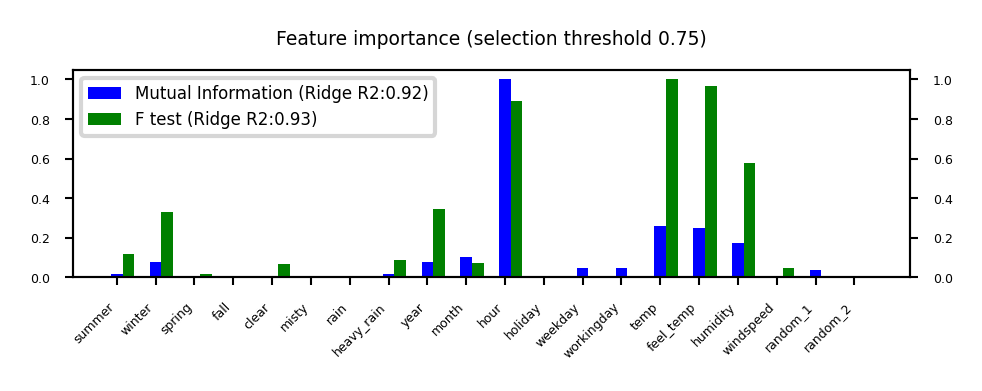

In [24]:
plot_feature_importances('MutualInformation', 'FTest', threshold=0.75)

### Further techniques
* Many more powerful techniques exist
    * Model-based: Random Forests, Linear models, kNN
    * Wrapping techniques (black-box search)
    * Permutation importance
* See the Data Preprocessing lecture.

## Feature Engineering
* Create new features based on existing ones
    * Polynomial features
    * Interaction features
    * Binning
* Mainly useful for simple models (e.g. linear models)
    * Other models can learn interations themselves
    * But may be slower, less robust than linear models

### Polynomials
* Add all polynomials up to degree $d$ and all products
    * Equivalent to polynomial basis expansions
$$[1, x_1, ..., x_p] \xrightarrow{} [1, x_1, ..., x_p, x_1^2, ..., x_p^2, ..., x_p^d, x_1 x_2, ..., x_{p-1} x_p]$$


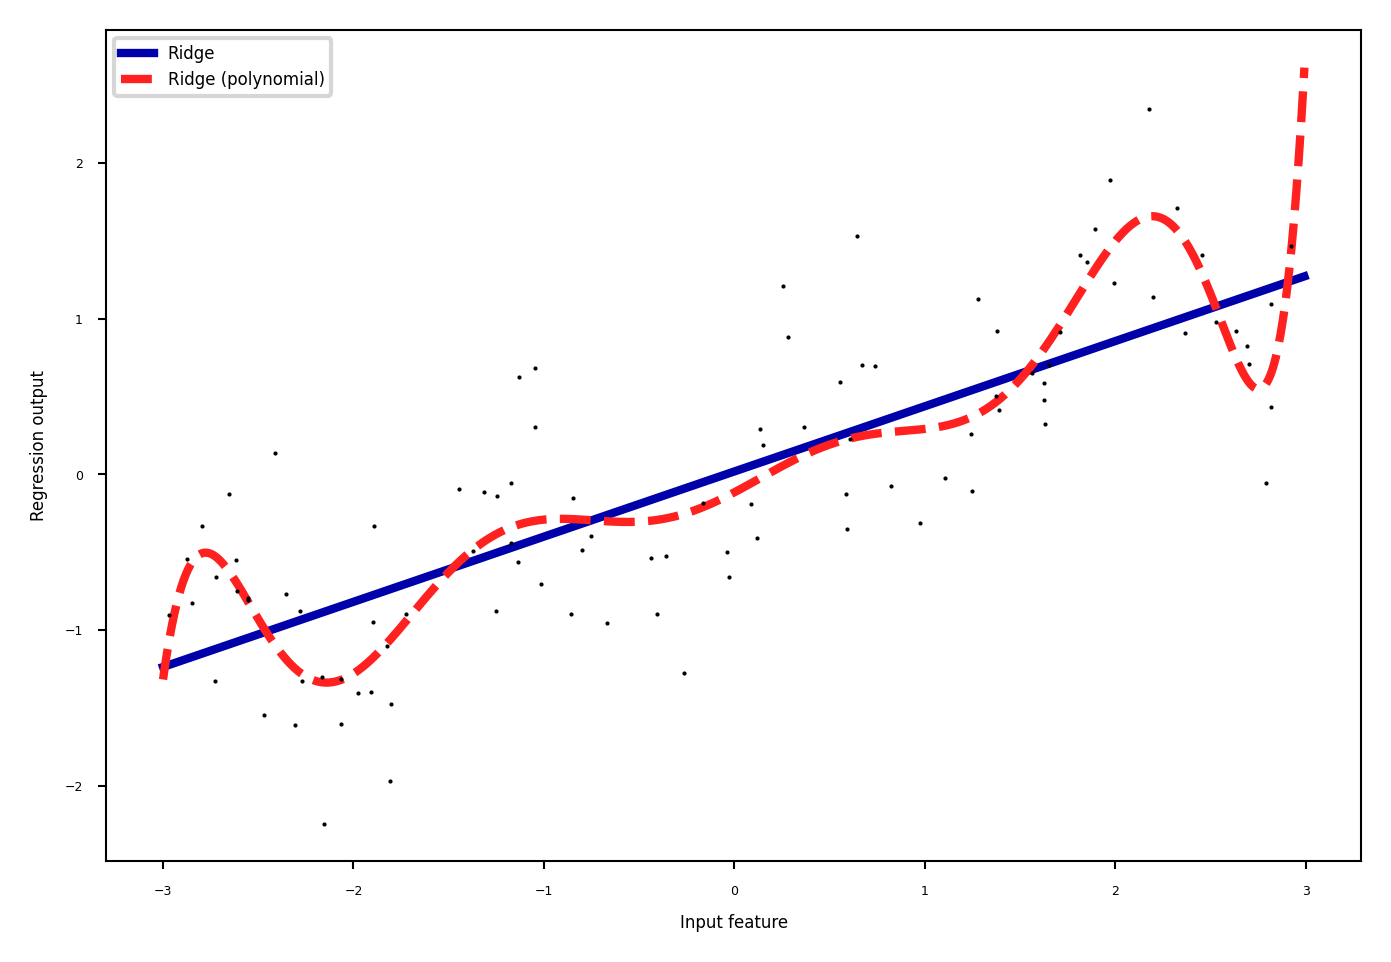

In [26]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures

# Wavy data
X, y = mglearn.datasets.make_wave(n_samples=100)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

# Normal ridge
lreg = Ridge().fit(X, y)
plt.rcParams['figure.figsize'] = [6*fig_scale, 4*fig_scale]
plt.plot(line, lreg.predict(line), lw=2, label="Ridge")

# include polynomials up to x ** 10
poly = PolynomialFeatures(degree=10, include_bias=False)
X_poly = poly.fit_transform(X)
preg = Ridge().fit(X_poly, y)
line_poly = poly.transform(line)
plt.plot(line, preg.predict(line_poly), lw=2, label='Ridge (polynomial)')

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best");

### Binning
- Partition numeric feature values into $n$ intervals (bins)
- Create $n$ new one-hot features, 1 if original value falls in corresponding bin
- Models different intervals differently (e.g. different age groups)

In [34]:
table_font_size = 20
heading_properties = [('font-size', table_font_size)]
cell_properties = [('font-size', table_font_size)]
dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

In [35]:
from sklearn.preprocessing import OneHotEncoder

# create 11 equal bins
bins = np.linspace(-3, 3, 5)
# assign to bins
which_bin = np.digitize(X, bins=bins)
# transform using the OneHotEncoder.
encoder = OneHotEncoder(sparse_output=False)
# encoder.fit finds the unique values that appear in which_bin
encoder.fit(which_bin)
# transform creates the one-hot encoding
X_binned = encoder.transform(which_bin)
# Plot transformed data
bin_names = [('[%.1f,%.1f]') % i for i in zip(bins, bins[1:])]
df_orig = pd.DataFrame(X, columns=["orig"])
df_nr = pd.DataFrame(which_bin, columns=["which_bin"])
# add the original features
X_combined = np.hstack([X, X_binned])
ohedf = pd.DataFrame(X_combined, columns=["orig"]+bin_names).head(3)
ohedf.style.set_table_styles(dfstyle)

,orig,"[-3.0,-1.5]","[-1.5,0.0]","[0.0,1.5]","[1.5,3.0]"
0,-0.752759,0.000000,1.000000,0.000000,0.000000
1,2.704286,0.000000,0.000000,0.000000,1.000000
2,1.391964,0.000000,0.000000,1.000000,0.000000


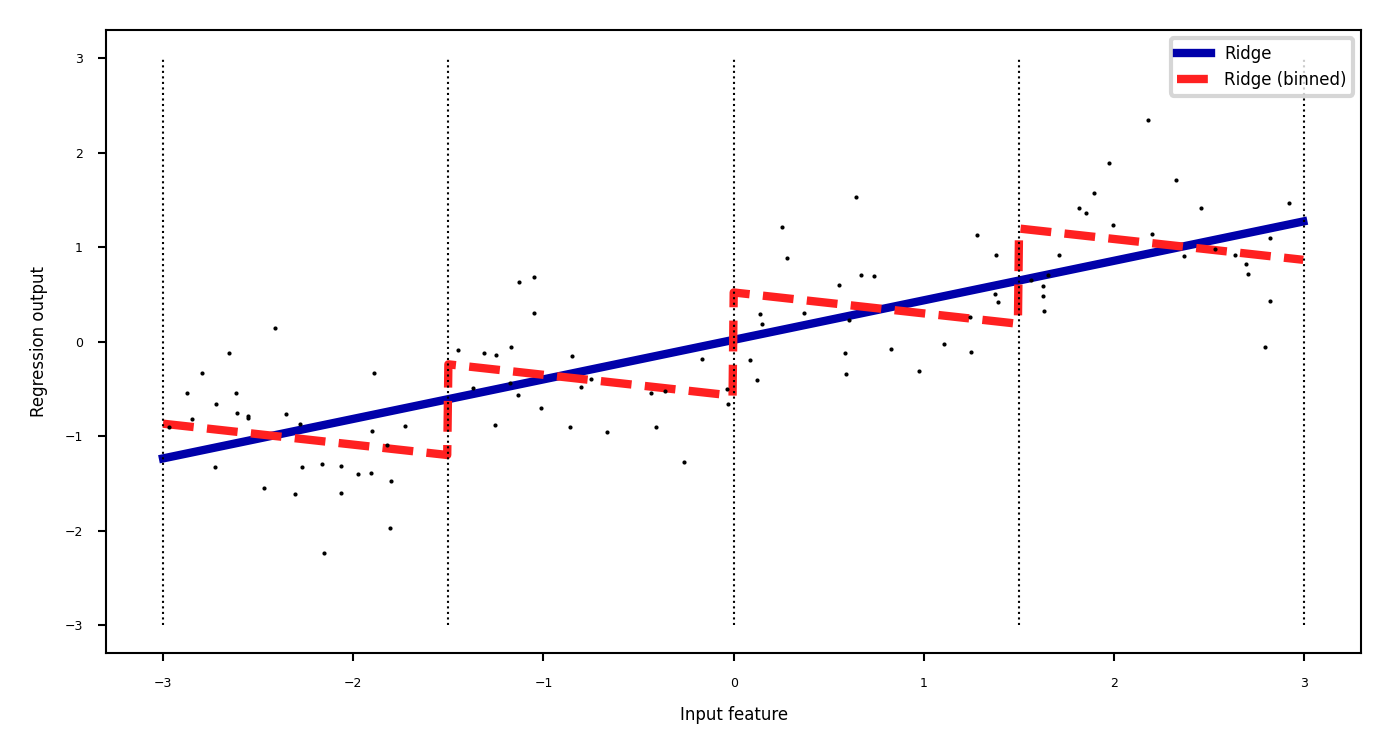

In [36]:
line_binned = encoder.transform(np.digitize(line, bins=bins))
reg = LinearRegression().fit(X_combined, y)

line_combined = np.hstack([line, line_binned])

plt.rcParams['figure.figsize'] = [6*fig_scale, 3*fig_scale]
plt.plot(line, lreg.predict(line), lw=2, label="Ridge")
plt.plot(line, reg.predict(line_combined), lw=2, label='Ridge (binned)')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.plot(X[:, 0], y, 'o', c='k');

### Binning + interaction features
* Add _interaction features_ (or _product features_ )
    * Product of the bin encoding and the original feature value
    * Learn different weights per bin

In [37]:
X_product = np.hstack([X_binned, X * X_binned])
bin_sname = ["b" + str(s) for s in range(4)] 
X_combined = np.hstack([X, X_product])
pd.set_option('display.max_columns', 10)
bindf = pd.DataFrame(X_combined, columns=["orig"]+bin_sname+["X*" + s for s in bin_sname]).head(3)
bindf.style.set_table_styles(dfstyle)

,orig,b0,b1,b2,b3,X*b0,X*b1,X*b2,X*b3
0,-0.752759,0.000000,1.000000,0.000000,0.000000,-0.000000,-0.752759,-0.000000,-0.000000
1,2.704286,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.704286
2,1.391964,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.391964,0.000000


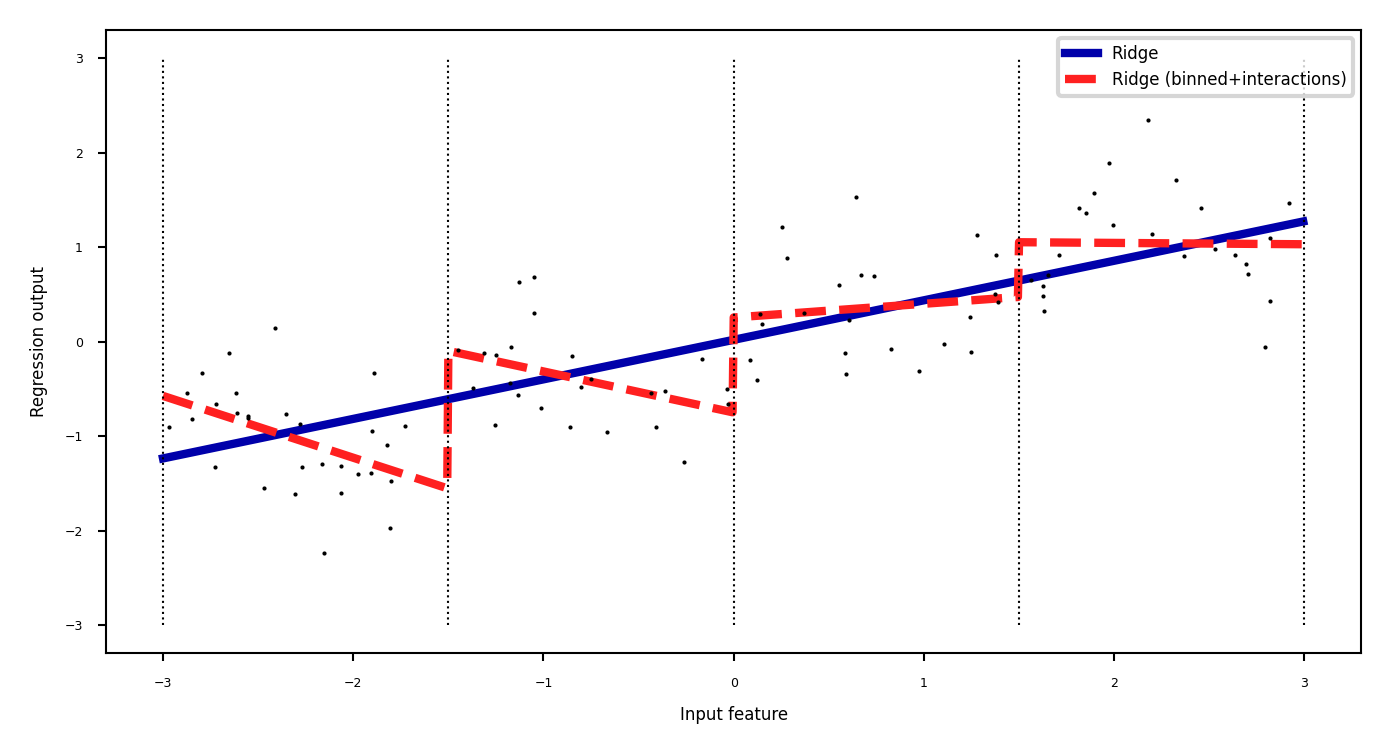

In [38]:
reg = LinearRegression().fit(X_product, y)

line_product = np.hstack([line_binned, line * line_binned])
plt.plot(line, lreg.predict(line), lw=2, label="Ridge")
plt.plot(line, reg.predict(line_product), lw=2, label='Ridge (binned+interactions)')

for bin in bins:
    plt.plot([bin, bin], [-3, 3], ':', c='k')

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best");

### Categorical feature interactions
* One-hot-encode categorical feature
* Multiply every one-hot-encoded column with every numeric feature
* Allows to built different submodels for different categories

In [39]:
df = pd.DataFrame({'gender': ['M', 'F', 'M', 'F', 'F'],
                   'age': [14, 16, 12, 25, 22],
                   'pageviews': [70, 12, 42, 64, 93],
                   'time': [269, 1522, 235, 63, 21]
                  })
df.head(3)
df.style.set_table_styles(dfstyle)

,gender,age,pageviews,time
0,M,14,70,269
1,F,16,12,1522
2,M,12,42,235
3,F,25,64,63
4,F,22,93,21


In [40]:
dummies = pd.get_dummies(df)
df_f = dummies.multiply(dummies.gender_F, axis='rows')
df_f = df_f.rename(columns=lambda x: x + "_F")
df_m = dummies.multiply(dummies.gender_M, axis='rows')
df_m = df_m.rename(columns=lambda x: x + "_M")
res = pd.concat([df_m, df_f], axis=1).drop(["gender_F_M", "gender_M_F"], axis=1)
res.head(3)
res.style.set_table_styles(dfstyle)

,age_M,pageviews_M,time_M,gender_M_M,age_F,pageviews_F,time_F,gender_F_F
0,14,70,269,True,0,0,0,False
1,0,0,0,False,16,12,1522,True
2,12,42,235,True,0,0,0,False
3,0,0,0,False,25,64,63,True
4,0,0,0,False,22,93,21,True


## Summary

* Data preprocessing is a crucial part of machine learning
    * Scaling is important for many distance-based methods (e.g. kNN, SVM, Neural Nets)
    * Selecting features can speed up models and reduce overfitting
    * Feature engineering is often useful for linear models
    * Many more techniques (e.g. missing value imputation, handling data imbalance,...) will be discussed in the data preprocessing lecture
* Pipelines allow us to encapsulate multiple steps in a convenient way
    * Avoids data leakage, crucial for proper evaluation
* Choose the right preprocessing steps and models in your pipeline
    * Cross-validation helps, but the search space is huge
    * Smarter techniques exist to automate this process (i.e. AutoML)